In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Downloads CIFAR-10 automatically and loads it into memory
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 784s 5us/step


In [77]:
from skimage import io, util

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (50000, 32, 32, 3) (50000, 1)
Test: (10000, 32, 32, 3) (10000, 1)


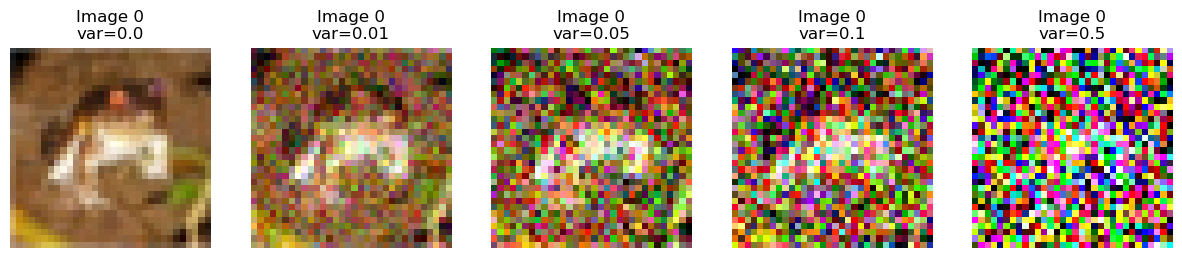

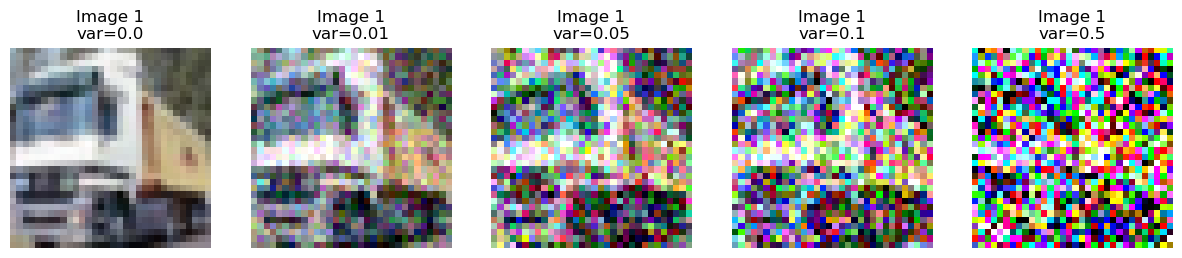

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, util

# Variances for Gaussian noise
variances = [0, 0.01, 0.05, 0.1, 0.5]

# Store results
results = []

for var in variances:
    noisy0 = util.random_noise(x_train[0], mode='gaussian', var=var)
    noisy1 = util.random_noise(x_train[1], mode='gaussian', var=var)
    
    # Save images
    fname0 = f"noisy0_{var}.jpg"
    fname1 = f"noisy1_{var}.jpg"
    io.imsave(fname0, (noisy0 * 255).astype("uint8"))
    io.imsave(fname1, (noisy1 * 255).astype("uint8"))
    
    # Append metadata for DataFrame
    results.append({"Image": "img0", "Variance": var, "Path": fname0, "Array": noisy0})
    results.append({"Image": "img1", "Variance": var, "Path": fname1, "Array": noisy1})

# Convert to DataFrame
df = pd.DataFrame(results)

# Pretty grid visualization
def show_noisy_grid(img_results, title_prefix="Image"):
    fig, axes = plt.subplots(1, len(img_results), figsize=(15, 3))
    for ax, row in zip(axes, img_results):
        ax.imshow(row["Array"])
        ax.set_title(f"{title_prefix}\nvar={row['Variance']}")
        ax.axis("off")
    plt.show()

# Show both grids
show_noisy_grid(df[df["Image"] == "img0"].to_dict("records"), "Image 0")
show_noisy_grid(df[df["Image"] == "img1"].to_dict("records"), "Image 1")



c:\Users\nunni\miniconda3\envs\venv-mlops\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


,Image,Variance,BRISQUE,PSNR,SSIM
0,img0,0.00,21.207521,inf,1.000000
1,img0,0.01,57.834952,22.293887,0.771548
2,img0,0.05,132.415193,16.238677,0.492910
3,img0,0.10,95.608272,13.988992,0.380623
4,img0,0.50,100.307013,10.560902,0.169367
5,img1,0.00,68.463023,inf,1.000000
6,img1,0.01,47.981871,22.055657,0.886460
7,img1,0.05,105.985368,16.230738,0.682619
8,img1,0.10,92.927321,14.198470,0.561470
9,img1,0.50,164.542277,10.576229,0.282766


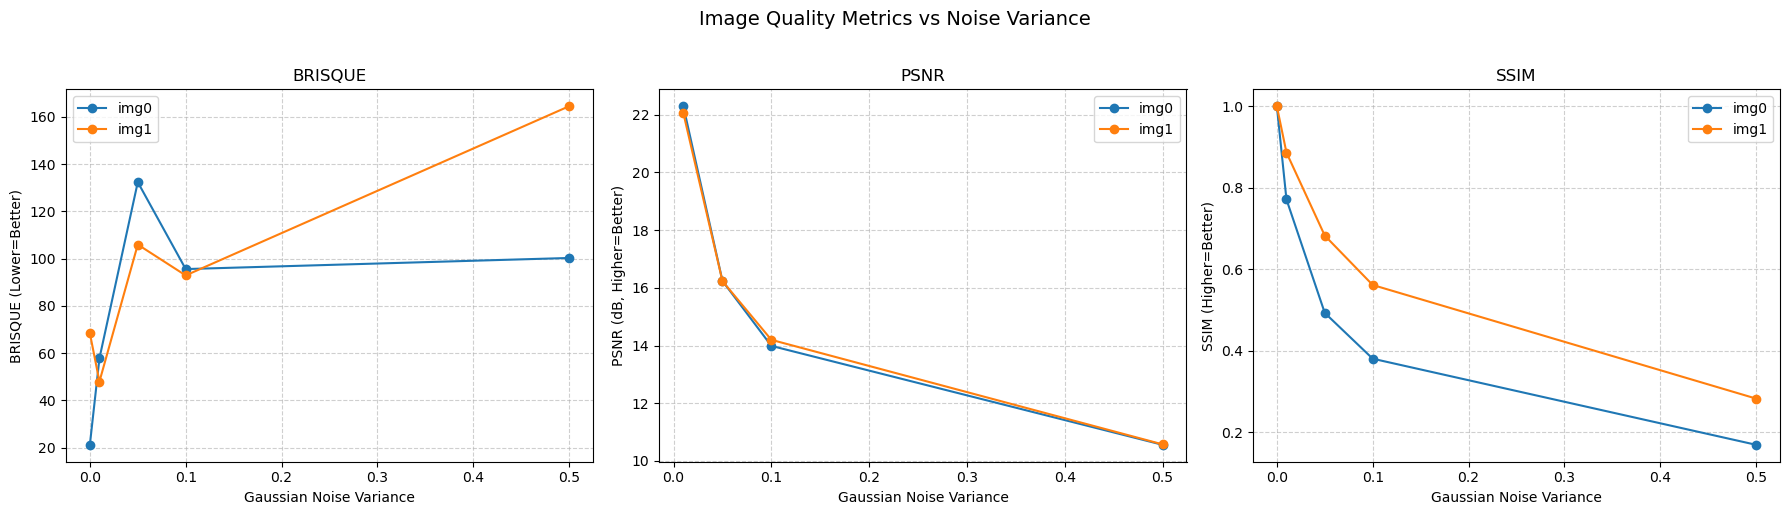

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from brisque import BRISQUE
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Create BRISQUE object
brisque = BRISQUE()

path = 'C:/Users/nunni/OneDrive/Skrivebord/Bachelor/Bachelor/'

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

# Ground truth reference images (make sure they are 8-bit for PSNR/SSIM)
ref0 = cv2.imread(path + var[0])  # BGR by default
ref0 = cv2.cvtColor(ref0, cv2.COLOR_BGR2RGB)  # convert to RGB to match reference
ref1 = cv2.imread(path + var1[0])  # BGR by default
ref1 = cv2.cvtColor(ref1, cv2.COLOR_BGR2RGB)  # convert to RGB to match reference

results = []

def evaluate_set(file_list, ref_img, img_id):
    for fname in file_list:
        noisy = cv2.imread(path + fname)  # BGR by default
        noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)  # convert to RGB to match reference

        # Extract variance from filename
        variance = float(fname.split("_")[-1].replace(".jpg", ""))

        # BRISQUE score
        b_score = brisque.score(noisy)

        # PSNR
        p_score = psnr(ref_img, noisy, data_range=255)

        # SSIM (multi-channel)
        s_score = ssim(ref_img, noisy, channel_axis=-1, data_range=255)

        results.append({
            "Image": img_id,
            "Variance": variance,
            "BRISQUE": b_score,
            "PSNR": p_score,
            "SSIM": s_score
        })

# Run evaluations
evaluate_set(var, ref0, "img0")
evaluate_set(var1, ref1, "img1")

# DataFrame
df_metrics = pd.DataFrame(results).sort_values(by=["Image", "Variance"])

display(df_metrics)

# Plot: BRISQUE, PSNR, SSIM vs variance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["BRISQUE", "PSNR", "SSIM"]
ylabels = ["BRISQUE (Lower=Better)", "PSNR (dB, Higher=Better)", "SSIM (Higher=Better)"]

for ax, metric, ylabel in zip(axes, metrics, ylabels):
    for img_id, group in df_metrics.groupby("Image"):
        ax.plot(group["Variance"], group[metric], marker="o", label=img_id)
    ax.set_title(metric)
    ax.set_xlabel("Gaussian Noise Variance")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

plt.suptitle("Image Quality Metrics vs Noise Variance", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
